## Fitting Spline kernel on CAMELS 

In [106]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [107]:
# import gdown
# gdown.download('https://drive.google.com/uc?id=1oy1cO8o2B8g3-PYxf6bCo3wVcZEjRSYf', quiet=True)
# !unzip CV_1.zip

In [108]:
%pylab inline
from tqdm import tqdm

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['step']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [109]:
import jax_cosmo as jc

mesh_shape= [64, 64, 64]
box_size  = [25., 25., 25.]
cosmo = jc.Planck15(Omega_c= 0.3 - 0.049, Omega_b=0.049, n_s=0.9624, h=0.6711, sigma8=0.8)

In [110]:
#import camels_library as cl
import readgadget

init_cond = 'CV_0/ICs/ics'

header   = readgadget.header(init_cond)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

ptype = [1] #dark matter is particle type 1
ids_i = np.argsort(readgadget.read_block(init_cond, "ID  ", ptype)-1)  #IDs starting from 0
pos_i = readgadget.read_block(init_cond, "POS ", ptype)[ids_i]/1e3     #positions in Mpc/h
vel_i = readgadget.read_block(init_cond, "VEL ", ptype)[ids_i]         #peculiar velocities in km/s

# Reordering data for simple reshaping
pos_i = pos_i.reshape(2,2,2,128,128,128,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
vel_i = vel_i.reshape(2,2,2,128,128,128,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
pos_i = (pos_i/BoxSize*64).reshape([256,256,256,3])[::2,::2,::2,:].reshape([-1,3])
vel_i = (vel_i / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::2,::2,::2,:].reshape([-1,3])
a_i   = 1./(1+redshift)

In [111]:
scales = []
poss = []
vels = []

# Loading all the intermediate snapshots
for i in tqdm(range(34)):
    snapshot='CV_0/snap_%03d.hdf5'%i
    
    header   = readgadget.header(snapshot)
    
    redshift = header.redshift     #redshift of the snapshot
    h        = header.hubble       #value of h
    
    ptype = [1] #dark matter is particle type 1
    ids = np.argsort(readgadget.read_block(snapshot, "ID  ", ptype)-1)     #IDs starting from 0
    pos = readgadget.read_block(snapshot, "POS ", ptype)[ids] / 1e3        #positions in Mpc/h
    vel = readgadget.read_block(snapshot, "VEL ", ptype)[ids]              #peculiar velocities in km/s

    # Reordering data for simple reshaping
    pos = pos.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    vel = vel.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    
    pos = (pos / BoxSize * 64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    vel = (vel / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    
    scales.append((1./(1+redshift)))
    poss.append(pos)
    vels.append(vel)

100%|██████████| 34/34 [03:07<00:00,  5.51s/it]


In [112]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import haiku as hk


from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, laplace_kernel, longrange_kernel
from jaxpm.nn import NeuralSplineFourierFilter
from jaxpm.utils import power_spectrum
#import numpyro 
rng_seq = hk.PRNGSequence(1)

In [113]:
# Run the reference simulation without correction at the same steps
resi = odeint(make_ode_fn(mesh_shape), [poss[0], vels[0]], jnp.array(scales), cosmo, rtol=1e-5, atol=1e-5)

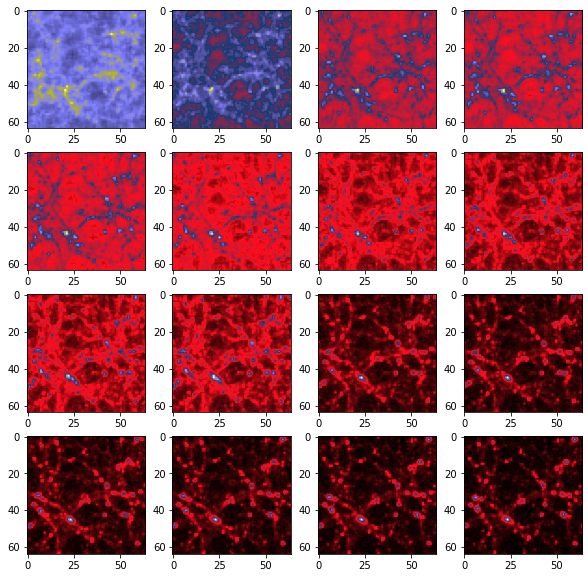

In [114]:
# High res simulation
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0), cmap='gist_stern', vmin=0)

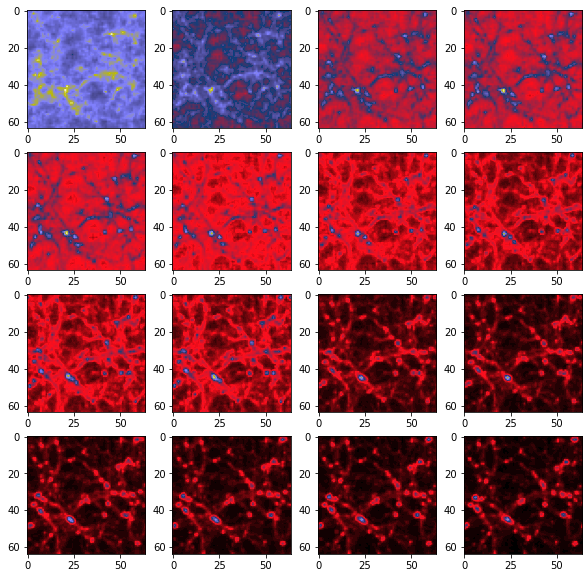

In [115]:
# JaxPM without correction
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), resi[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

In [116]:
k, pk_ref = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

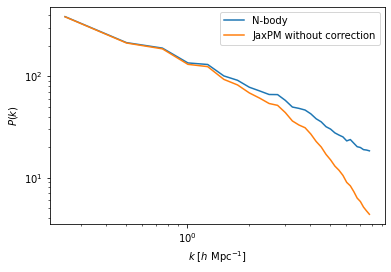

In [117]:
loglog(k,pk_ref, label='N-body')
loglog(k,pk_i, label='JaxPM without correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

### Fitting neural network

In [120]:
from  Net3d import*

# Instantiate the neural network

model = hk.without_apply_rng(hk.transform(lambda x : SpectralConv3(modes1=32,modes2=32,modes3=32)(x)))
#params = model.init(next(rng_seq),jnp.zeros([1,1,64,64,33]))

# model = hk.without_apply_rng(hk.transform(lambda x,a : NeuralSplineFourierFilter(n_knots=16, latent_size=32)(x,a)))
# params = model.init(next(rng_seq), jnp.zeros([64]), jnp.ones([1]))

In [118]:
class ComplexSpectral(hk.Module):

    def __init__(self,width,modes1=8,modes2=8,modes3=8, padding=3,name="PaperNetwork"):
        
        super().__init__(name=name)
        self.modes1= modes1
        self.modes2= modes2
        self.modes3= modes3
        self.width = width
        self.padding=6
        self.conv0 = SpectralConv3(1, self.width, self.modes1, self.modes2, self.modes3, name='l0')
        self.conv1 = SpectralConv3(self.width, 1, self.modes1, self.modes2, self.modes3, name='l1')
        # self.conv2 = SpectralConv3(self.width, self.width, self.modes1, self.modes2, self.modes3, name='l2')
        # self.conv3 = SpectralConv3(self.width, self.width, self.modes1, self.modes2, self.modes3, name='l3')

        
    def __call__(self,x):

        
        #print("Start",x.shape)
        
        dim1,dim2,dim3=x.shape
        #Fourier Space
        print(x.shape)
        x1 = x[jax.numpy.newaxis,jax.numpy.newaxis,...]
        x1 = self.conv0(x1)
        x1 = np.squeeze(x1, axis=0)
        x1=jnp.fft.irfftn(x1,s=(dim1,dim2,dim3+31))
        print(x1.shape)
        x = jax.nn.relu(x1)
        print(x.shape)
        
        #Another Spectral 
        x1 = jnp.fft.rfftn(x,s=(dim1,dim2,dim3+31))
        x1 = x1[jax.numpy.newaxis,...]
        x1 = self.conv1(x1)
        #x1=jnp.fft.irfftn(x1,s=(dim1,dim2,dim3))
        x1 = np.squeeze(x1, axis=0)
        #x = jax.nn.relu(x1)
        print(x1.shape)
        
        return x1



# Instantiate the neural network
model = hk.without_apply_rng(hk.transform(lambda x : ComplexSpectral(width=20)(x)))
#params = model.init(next(rng_seq),jnp.zeros([64,64,33]))

In [124]:
def neural_nbody_ode(state, a, cosmo, params):
    """
    state is a tuple (position, velocities)
    """
    pos, vel = state
    
    kvec = fftk(mesh_shape)

    delta = cic_paint(jnp.zeros(mesh_shape), pos)
    
    delta_k = jnp.fft.rfftn(delta)
    
    # Computes gravitational potential
    pot_k = delta_k * laplace_kernel(kvec) * longrange_kernel(kvec, r_split=0)
    
    # Apply a correction filter
    # kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))
    # pot_k = pot_k *(1. + model.apply(params, kk, jnp.atleast_1d(a)))


    pot_k = pot_k[jax.numpy.newaxis,jax.numpy.newaxis,...]
    pot_k = pot_k + model.apply(params, pot_k)
    pot_k=jax.numpy.squeeze(pot_k)
    
    # Computes gravitational forces
    forces = jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k), pos) 
                      for i in range(3)],axis=-1)
    
    #modelx=model.apply(params, delta)
    #forcesML=jnp.stack([cic_read(modelx[...,i],pos) for i in range(3)],axis=-1)

    # forces=  model.apply(params, delta) # +forces
    #forces= forces+ forcesML
    forces = forces * 1.5 * cosmo.Omega_m

    # Computes the update of position (drift)
    dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel
    
    # Computes the update of velocity (kick)
    dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces
    
    return dpos, dvel

In [92]:
# Precomputing a few data stuff
ref_pos = jnp.stack(poss, axis=0)
ref_vel = jnp.stack(vels, axis=0)
ref_pk = jax.vmap(lambda x: power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), x)),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)[1])(ref_pos)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


In [93]:
@jax.jit
def loss_fn(params):
  res = odeint(neural_nbody_ode, [poss[0], vels[0]], jnp.array(scales), cosmo, params, rtol=1e-5, atol=1e-5) 
  distance = jnp.sum((res[0] - ref_pos)**2, axis=-1)
  w = jnp.where(distance < 100, distance, 0.)

  pk = jax.vmap(lambda x: power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), x)),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)[1])(res[0])

  # Optional lines to include velocity in the loss
  #   vel = jnp.sum((res[1] - ref_vel)**2, axis=-1)
  #   wv = jnp.where(distance < 100, vel, 0.)

  # This loss function contains a penalty on the position of the particles + we want the correct power spectrum
  return  jnp.mean(jnp.sum((pk/ref_pk -1)**2,axis=-1)) +jnp.mean(w)  #0.001*jnp.mean(wv) + jnp.mean(w)

@jax.jit
def update(params, opt_state):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

In [ ]:
losses = []


In [97]:
import optax
lr_fun= optax.cosine_decay_schedule(0.5, 1000 , alpha=0.0) #0.1 for 400steps, 0.01
#learning_rate=0.002
optimizer = optax.adam(lr_fun)
opt_state = optimizer.init(params)

In [99]:
for step in tqdm(range(600)):
  l, params, opt_state = update(params, opt_state)
  if(step%10==0 and step!=0):
    print("Step: ", step, " Loss: ",l)
    #pickle.dump( params, open( "Spectral16mod"+str(step)+"step_CV0.params", "wb" ) )
  losses.append(l)

  2%|▏         | 11/600 [00:53<25:44,  2.62s/it] 

Step:  10  Loss:  3.460782


  4%|▎         | 21/600 [01:18<23:49,  2.47s/it]

Step:  20  Loss:  2.7301862


  5%|▌         | 31/600 [01:43<23:43,  2.50s/it]

Step:  30  Loss:  2.3595612


  7%|▋         | 41/600 [02:08<23:34,  2.53s/it]

Step:  40  Loss:  2.1009297


  8%|▊         | 51/600 [02:34<23:18,  2.55s/it]

Step:  50  Loss:  2.044736


 10%|█         | 61/600 [02:59<22:58,  2.56s/it]

Step:  60  Loss:  1.8280113


 12%|█▏        | 71/600 [03:25<22:43,  2.58s/it]

Step:  70  Loss:  1.729498


 14%|█▎        | 81/600 [03:51<22:12,  2.57s/it]

Step:  80  Loss:  1.6143624


 15%|█▌        | 91/600 [04:16<21:48,  2.57s/it]

Step:  90  Loss:  1.5495033


 17%|█▋        | 101/600 [04:42<21:21,  2.57s/it]

Step:  100  Loss:  1.4920661


 18%|█▊        | 111/600 [05:08<21:02,  2.58s/it]

Step:  110  Loss:  1.4497281


 20%|██        | 121/600 [05:34<20:41,  2.59s/it]

Step:  120  Loss:  1.4395278


 22%|██▏       | 131/600 [06:00<20:15,  2.59s/it]

Step:  130  Loss:  1.3917229


 24%|██▎       | 141/600 [06:26<19:50,  2.59s/it]

Step:  140  Loss:  1.3484733


 25%|██▌       | 151/600 [06:51<19:24,  2.59s/it]

Step:  150  Loss:  1.3188816


 27%|██▋       | 161/600 [07:17<18:58,  2.59s/it]

Step:  160  Loss:  1.2892187


 28%|██▊       | 171/600 [07:43<18:33,  2.59s/it]

Step:  170  Loss:  1.2798545


 30%|███       | 181/600 [08:09<18:07,  2.60s/it]

Step:  180  Loss:  1.2587411


 32%|███▏      | 191/600 [08:35<17:41,  2.60s/it]

Step:  190  Loss:  1.232903


 34%|███▎      | 201/600 [09:01<17:14,  2.59s/it]

Step:  200  Loss:  1.2135592


 35%|███▌      | 211/600 [09:27<16:48,  2.59s/it]

Step:  210  Loss:  1.2179127


 37%|███▋      | 221/600 [09:53<16:28,  2.61s/it]

Step:  220  Loss:  1.188417


 38%|███▊      | 231/600 [10:19<15:59,  2.60s/it]

Step:  230  Loss:  1.1664342


 40%|████      | 241/600 [10:45<15:34,  2.60s/it]

Step:  240  Loss:  1.1551695


 42%|████▏     | 251/600 [11:11<15:09,  2.61s/it]

Step:  250  Loss:  1.1619903


 44%|████▎     | 261/600 [11:37<14:42,  2.60s/it]

Step:  260  Loss:  1.140457


 45%|████▌     | 271/600 [12:04<14:20,  2.62s/it]

Step:  270  Loss:  1.1151676


 47%|████▋     | 281/600 [12:30<13:53,  2.61s/it]

Step:  280  Loss:  1.1221082


 48%|████▊     | 291/600 [12:56<13:27,  2.61s/it]

Step:  290  Loss:  1.1051803


 50%|█████     | 301/600 [13:22<12:58,  2.60s/it]

Step:  300  Loss:  1.0917069


 52%|█████▏    | 311/600 [13:48<12:33,  2.61s/it]

Step:  310  Loss:  1.0798336


 54%|█████▎    | 321/600 [14:14<12:08,  2.61s/it]

Step:  320  Loss:  1.0692487


 55%|█████▌    | 331/600 [14:40<11:43,  2.61s/it]

Step:  330  Loss:  1.0808799


 57%|█████▋    | 341/600 [15:06<11:18,  2.62s/it]

Step:  340  Loss:  1.0607535


 58%|█████▊    | 351/600 [15:33<10:48,  2.60s/it]

Step:  350  Loss:  1.0483991


 60%|██████    | 361/600 [15:59<10:22,  2.60s/it]

Step:  360  Loss:  1.039633


 62%|██████▏   | 371/600 [16:25<09:55,  2.60s/it]

Step:  370  Loss:  1.0311897


 64%|██████▎   | 381/600 [16:51<09:29,  2.60s/it]

Step:  380  Loss:  1.0228432


 65%|██████▌   | 391/600 [17:17<09:04,  2.60s/it]

Step:  390  Loss:  1.0193118


 67%|██████▋   | 401/600 [17:43<08:38,  2.60s/it]

Step:  400  Loss:  1.0146096


 68%|██████▊   | 411/600 [18:09<08:11,  2.60s/it]

Step:  410  Loss:  1.0120773


 69%|██████▉   | 414/600 [18:19<08:14,  2.66s/it]


KeyboardInterrupt: 

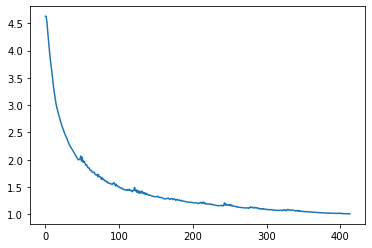

In [100]:
plot(losses)

In [ ]:
col = cm.viridis(np.linspace(0.,1.0,len(scales[::2])))   

kvals = jnp.logspace(-2.,0,100)*sqrt(3)

for i, a in enumerate(scales[::2]): 
    semilogx(kvals, model.apply(params, kvals , jnp.atleast_1d(a)), color=col[i])

sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0., vmax=1))
plt.colorbar(sm, label='a')

#xlim(kvals[0], 1)
#ylim(0,5)
grid()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
#plt.savefig('../figures/filter_k.pdf',bbox_inches='tight')

TypeError: <lambda>() takes 1 positional argument but 2 were given

In [121]:
import pickle
with (open("Spectral_CV0.params", "rb")) as openfile:
    while True:
        try:
            paramsLoad=pickle.load(openfile)
        except EOFError:
            break

In [125]:
res = odeint(neural_nbody_ode, [poss[0], vels[0]], jnp.array(scales), cosmo, paramsLoad, rtol=1e-5, atol=1e-5)

Spectral Initialized


/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/ops/scatter.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


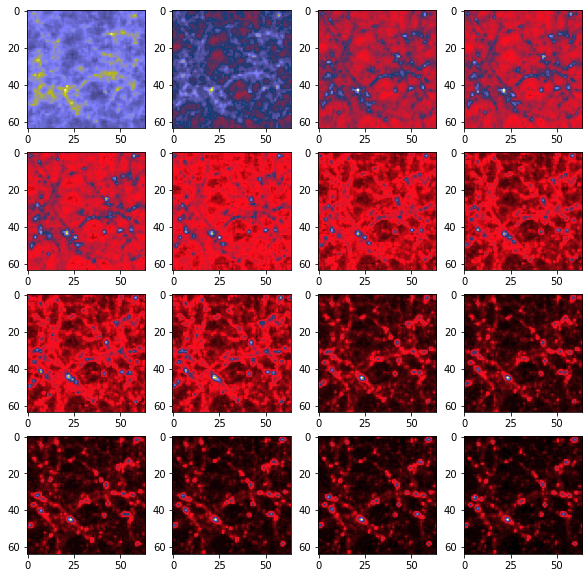

In [126]:
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), res[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

In [127]:
k, pk_ref = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_c = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), res[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

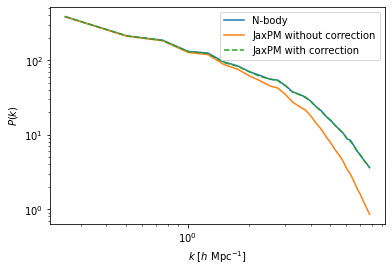

In [128]:
loglog(k, pk_ref, label='N-body')
loglog(k, pk_i, label='JaxPM without correction')
loglog(k, pk_c, '--', label='JaxPM with correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

In [ ]:
pk_c[-5:]

DeviceArray([5.922512 , 5.1892266, 4.596321 , 4.083793 , 3.6099901], dtype=float32)

In [ ]:
pk_ref[-5:]

DeviceArray([5.966447 , 5.3237104, 4.583368 , 4.090417 , 3.6037705], dtype=float32)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/hom

(0.0, 1.5)

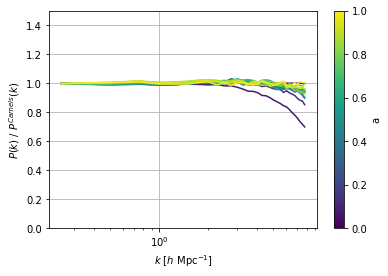

In [ ]:
for i, a in enumerate(scales[::2]): 
    k, pk_ref = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), poss[::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    k, pk_c = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), res[0][::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    semilogx(k, pk_c/pk_ref, color=col[i])
    
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$ P(k) \ / \ P^{Camels}(k)$")
plt.colorbar(sm, label='a')
plt.grid(True)
plt.ylim(0.,1.5)
#plt.savefig('../figures/camels_residuals_pk_pos2.png',dpi=150)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/hom

(0.0, 1.5)

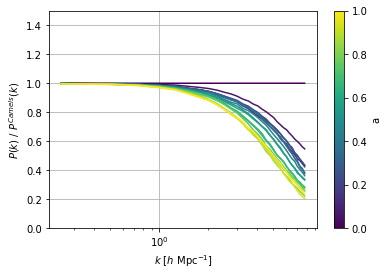

In [ ]:
for i, a in enumerate(scales[::2]): 
    k, pk_ref = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), poss[::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    k, pk_i = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), resi[0][::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    semilogx(k, pk_i/pk_ref, color=col[i])
    
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$ P(k) \ / \ P^{Camels}(k)$")
plt.colorbar(sm, label='a')
plt.grid(True)
plt.ylim(0.,1.5)
#plt.savefig('../figures/camels_residuals_nocorrection2.png',dpi=150)

In [105]:
import pickle
pickle.dump( params, open( "ComplexSpectralXXX_CV0.params", "wb" ) )

In [ ]:

# with (open("Spectral_CV0.params", "rb")) as openfile:
#     while True:
#         try:
#             paramsLoad=pickle.load(openfile)
#         except EOFError:
#             break

In [ ]:
paramsLoad

NameError: name 'paramsLoad' is not defined